# 非線形なモデルとPreprocessing
## 前回行ったこと
 - 交差検証
 - グリッドサーチによるハイパーパラメータチューニング

## 今回行うこと
- 非線形なモデルを動かす
- 特徴ベクトルに対する学習前の処理

## （復習）データの読み込み・特徴ベクトルの構築
one-hotエンコーディングを用いた特徴ベクトルを再び作ります．
もう詳しく説明することはしません．
全て一つのセルにまとめました．
詳細は前回の資料を参照してください．

In [1]:
import numpy as np
import pandas as pd 

# Colabの場合は以下のコメントアウト外す
#from google.colab import drive
#drive.mount('/content/drive') # google driveをマウント（＝Colabから使えるようにする）

d_train = pd.read_csv("data/train.csv") # 訓練データを読み込む
d_test = pd.read_csv("data/test.csv") # テストデータを読み込む
# Google Colabの場合
#d_train = pd.read_csv("drive/My Drive/data/train.csv") # 訓練データを読み込む．
#d_test = pd.read_csv("drive/My Drive/data/test.csv") # テストデータを読み込む．

print("訓練データとテストデータの数を取得")
n_train = len(d_train)
n_test = len(d_test)
print(f"訓練データ数：{n_train}，テストデータ数：{n_test}")

# targetの値
y_train = d_train.pop('AveragePrice')
y_train = y_train.values # numpyのarrayに変換
print(y_train)

# one-hot encoding
d_train_test = pd.concat([d_train, d_test], axis=0) # 訓練とテストを連結
columns_cat = ["Date", "type", "region"] # カテゴリカル変数の列名

d_train_test_onehot = pd.get_dummies(d_train_test, columns=columns_cat) # get_dummiesを使ってone-hotエンコーディング
d_train_onehot = d_train_test_onehot[:n_train] # d_train_test_onehotの訓練データ部分
d_test_onehot = d_train_test_onehot[n_train:] # d_train_test_onehotのテストデータ部分
X_train = d_train_onehot.values # np.arrayに変換
X_test = d_test_onehot.values  # np.arrayに変換

訓練データとテストデータの数を取得
訓練データ数：12774，テストデータ数：5475
[1.67 1.53 1.48 ... 1.5  1.41 1.21]


いい加減しつこい気もしますが，復習と予測結果の比較のために`LinearRegression`を動かしておきます．
ハイパーパラメータ（学習するのではなく，ユーザが決める要素）はここでは`fit_intercept=False`，`normalize=False`とします．

In [2]:
from sklearn.linear_model import LinearRegression # LinearRegressionを使えるようにする
lr = LinearRegression(fit_intercept=False, normalize=False) # インスタンスの作成
lr.fit(X_train, y_train)
y_pred_test_lr = lr.predict(X_test)
print(y_pred_test_lr)

[1.81557459 1.10866466 0.82345937 ... 1.57020038 1.44596604 1.87548053]


## 非線形なモデルを動かす
これまでは線形回帰とリッジ回帰を動かしてきました．
これらはどちらもモデルとしては同じで，以下の式で表される線形モデルです：
$$y(\mathbf{x};\mathbf{w}) = \mathbf{w}^\top \mathbf{x},$$
ここで$\mathbf{w} \in \mathbb{R}^d$は学習する重みです（簡単のため，バイアス項（bias term）（あるいは切片（intercept））は無視します．

線形モデルは予測モデルの中でも最も単純でわかりやすいものの一つです．
しかし，現実の多くの問題はこの単純なモデルで説明することができないことが多いです．
例えば，**全ての特徴の値が2倍になった時，線形モデルの予測の値も2倍**になりますが，この性質がどのような問題でも望ましいとは限りません．

また，各特徴の要素に対して別々の重みを掛けてその結果を足しているだけで，**特徴同士の相互作用**のようなものを一切考えていません．
アボカドの例ですと，例えば，「日付は日付」「場所は場所」で独立に考えています．
したがって，線形モデルにおいて，日付がいつであろうとも場所ごとの傾向・バイアスは変わらず，同様にどの場所であろうとも日付ごと（正確には週ごと）の傾向・バイアスは変わりません．
しかし，場所によって日付ごと（週ごと）の傾向は変わる可能性があります．
例えば（あくまで例えばです），あるアボカドの栽培地域で何らかの天候に関連する災害・被害があったとき，その地域で生産されるアボカドを主に仕入先とする地域ではアボカドの値段に影響があると考えられますが，一方で，異なる地域で栽培されるアボカドを仕入先とする地域では影響を受けない（小さい），といったことがあるかもしれません．
しかし，線形モデルではそのようなことを考慮することができません．

そこで今回は**非線形なモデル**を使ってみることにします．
今回はsklearnによって提供されている非線形なモデルの中から適当に選んで使ってみます．
勿論，モデルの持つ非線形性が実際のデータとかけ離れていれば，（妥当なモデルと比べて）上手くいきません．
また，非線形なモデルは表現能力（フィッティング能力）が高いことが多く，データが少ない場合は過学習を起こしてしまう可能性もあります．
そのことに注意しながら使ってみましょう．

### 多層パーセプトロン（Multi-layer perceptron，MLP）を動かす
sklearnには多数の非線形なモデルが実装されています．
今回はその中でも，[多層パーセプトロン（Multi-layer perceptron, MLP）](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)を動かしてみます．
**MLPはニューラルネットワーク**の一種で，多層のニューラルネットワークの中では最もベーシックなものです．
MLPは，数理的には，
1. ベクトルに行列を掛ける
2. 活性化関数と呼ばれる非線形な関数を噛ませる

を繰り返したモデルです．
MLPをノード（点）とエッジ（線）を用いてグラフィカルに表現すると，上の2つの演算を繰り返した回数だけ，入力と出力の間に「層」があるように見えます．
そのため，上の2つの演算を行う回数を中間層（隠れ層）の数と言い，掛ける行列のことを中間層の重み（行列）と呼びます．
中間層の重み行列がMLPの学習するパラメータで，**勾配法**と呼ばれる方法で学習を行います．
勾配法（とくに，ここでは誤差関数の最小化を考えることにするので，勾配降下法）は，簡単に説明すると以下のような反復を行うアルゴリズムです：

1. パラメータ$\mathbf{\Theta}$の初期値を定め，以下の2と3を収束するまで繰り返す．
2. 最小化したい関数$L$に対するパラメータの勾配$\nabla L(\mathbf{\Theta})$を計算する．ニューラルネットワークにおいては，この勾配の計算を**誤差逆伝播法（Backpropagation）**と呼ばれる方法で効率よく行う．
3. 2で求めた勾配を使ってパラメータを少し動かす．最も単純な方法（＝厳密に単に勾配降下法と言った場合は）では以下のように動かす：
    $$\mathbf{\Theta} \leftarrow \mathbf{\Theta} - \eta \nabla L(\mathbf{\Theta}),$$
ここで，$\eta > 0$は学習率やステップサイズと呼ばれるハイパーパラメータで，一回の反復でどの程度パラメータを動かすかを表す．

一応簡単に説明しましたが，これでは不十分・わかりにくいように思います．
詳細は，例えば[scikit-learnの解説](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised)や，[授業で使っている教科書](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)や，その他多数の書籍やWeb上の記事を参考にしてみてください（「人工知能」の授業で触れているのではないかとも思いますが）．

では実際に使ってみます．
まずはimportですが，回帰のためのMLPは`NLPRegressor`という名前で，`sklearn.neural_network`の中にあります．

In [3]:
from sklearn.neural_network import MLPRegressor

それではとりあえず，デフォルトのパラメータで使ってみましょう．
デフォルト設定のモデルの評価（NOTチューニング）をするために，`cross_validate`をimportします．
また，後のため，`GridSearchCV`もimportします．

In [4]:
from sklearn.model_selection import cross_validate, GridSearchCV

前回と同様に，`cross_validate`で評価をしてみます．
`cross_validate`には，学習・評価をしたいモデルとデータ，そして分割数とスコア関数（の名前）を与えるのでした．
前回同様，分割数`cv=5`とし，スコア関数は`"neg_mean_squared_error"`とします．
`cross_validate`を動かすと`scores`という辞書オブジェクトが返ってきます．
`"test_score"`というキーで交差検証のスコアを取得できるのでした．
5回のスコアとその平気を最後にprintします．
結局，以下のようになります（前回のほぼコピペ）．

In [5]:
mlp = MLPRegressor()
scores = cross_validate(mlp, X_train, y_train, cv=5, 
                        scoring="neg_mean_squared_error")
print(f"交差検証の5回のスコア：{-scores['test_score']}")
print(f"交差検証の平均スコア：{-np.mean(scores['test_score'])}")

交差検証の5回のスコア：[ 2323362.3758501  12500545.84101669  2172804.89995638  5717256.75208008
  3599557.01438392]
交差検証の平均スコア：5262705.376657436


少し待った時間がかかった結果，**トンデモナイスコア**が返ってきました，何だこれ！？
過学習にしてもひどいですね．

ひどい過学習をしているのかなと思いつつ，一応，**訓練データに対するスコア**を確認してみます．
「訓練データに対するスコアを参考にするな」と以前の資料では言ったように思いますが，訓練データに対するスコアは以下のように使うことができます：**訓練データに対するスコアも悪い場合，そもそも学習ができていない**ので，**プログラムの使い方を大きく間違っている**・**そもそもプログラムにバグがある**（今回は考えにくいですが，自身でコアのアルゴリズムを実装した場合はあり得ます）と言ったことを検出できます（つまり，**過学習以前の問題**が起こっている）．
この場合，ドキュメントを注意深く読み直す必要があります．

`cross_validate`では，`return_train_score`という引数を`True`にすることで，訓練時のスコアも取得できます．
`train_score`というキーでアクセスできます（`cross_validate`は辞書型オブジェクトを返すのでしたね）．
ちょっと面倒ですが，もう一度交差検証をしてみます．

In [6]:
mlp = MLPRegressor()
scores = cross_validate(mlp, X_train, y_train, cv=5, 
                        scoring="neg_mean_squared_error",
                        return_train_score=True)
print(f"交差検証の5回のスコア：{-scores['test_score']}")
print(f"交差検証の平均スコア：{-np.mean(scores['test_score'])}")

print(f"交差検証の5回の訓練スコア：{-scores['train_score']}")
print(f"交差検証の平均訓練スコア：{-np.mean(scores['train_score'])}")

交差検証の5回のスコア：[ 1992833.28968998 51036963.73792981  3777703.24596244  2829879.41263
  1736710.78743728]
交差検証の平均スコア：12274818.094729904
交差検証の5回の訓練スコア：[ 2080180.762985   80841653.46863268  4919555.29392469  2283263.25443278
  1347239.05828947]
交差検証の平均訓練スコア：18294378.367652927


……ということで[ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)を読みに行きましょう．
ハイパーパラメータの数に圧倒されるかもしれませんが，どうか諦めないでください．
いくつかのパラメータに関して簡単に見ていきます．
- `hidden_layer_sizes`：intのタプル（リストのようなもの），隠れ層（中間層）のユニット数．例えば，`(100, 50, 20)`を指定すると，中間層の数が3つで，入力に近い方から順に中間層のユニット数が100, 50, 20となる．中間層の数は「行列を掛ける」「活性化関数を噛ませる」回数に対応し，ユニット数は行列を掛けた後のベクトルの要素数に対応します．つまり，ネットワークの構造（深さと広さ）を定めるものです．
- `activation`：string，活性化関数（行列を掛けた後に作用させる非線形な関数）．ここでは，
  - `"identity"`：恒等関数（$g(x)=x$）
  - `"logistic"`：ロジスティックシグモイド関数（$g(x)=1 / [1+\exp (-x)]$）
  - `"tanh"`：ハイパボリックタンジェント
  - `"relu"`：ランプ関数（$g(x)= \max (0, x)$)
  
  の4つを選択できる．デフォルトは`"relu"`．
- `solver`：string，最適化手法．MLPは勾配法で最適化すると言いましたが，一口に勾配法と言っても実は色々あり，ここでは，
  - `"lbfgs"`：準ニュートン法（quasi-newton method）と呼ばれる方法の一種．ヘッセ行列（＝二回微分）を近似し，上手く用いる．
  - `"sgd"`：確率的勾配降下法（stochastic gradient descent, SGD），一回の反復に全てのデータではなく一部のデータのみを用いる．
  - `"adam"`：SGDの一種で，勾配の使い方・ステップサイズに色々と工夫が施されている．
  
  の3つを指定できる．デフォルトは`"adam"`．
- `alpha`：float，正則化項の強さ（Ridge回帰と同じ）．
- `batch_size`：int， SGD・Adamにおいて，一回の反復で用いるデータの数．
- `learning_rate_init`：float，初期学習率．デフォルトは`0.001`．
- `max_iter`：int，最大反復回数．デフォルトは200.
- `beta_1`, `beta_2`：float，`"Adam"`のハイパーパラメータ．

ちょっと疲れたのでこの辺にしておきます．
まず，最初の`hidden_layer_sizes`と`activation`は，ネットワークの構造を決めるものなので性能に直結しそうですね．
また，最適化アルゴリズムの選択および最適化アルゴリズムのハイパーパラメータの選択も非常に重要です．
ここではとりあえず，他のハイパーパラメータはそのままで，先程試した`"relu"`以外の活性化関数を用いて交差検証で評価してみましょう

In [7]:
for activation in ["identity", "logistic", "tanh"]:
    print(f"活性化関数：{activation}")
    mlp = MLPRegressor(activation=activation)
    scores = cross_validate(mlp, X_train, y_train, cv=5, 
                            scoring="neg_mean_squared_error")
    print(f"交差検証の5回のスコア：{-scores['test_score']}")
    print(f"交差検証の平均スコア：{-np.mean(scores['test_score'])}\n")

活性化関数：identity
交差検証の5回のスコア：[7.50153718e+05 7.22792391e+01 1.12904578e+08 5.35382391e+06
 3.02602088e+07]
交差検証の平均スコア：29853767.343822487

活性化関数：logistic
交差検証の5回のスコア：[0.12962243 0.1218483  0.12786178 0.12736871 0.12544793]
交差検証の平均スコア：0.12642983042065764

活性化関数：tanh
交差検証の5回のスコア：[0.12666944 0.11986777 0.12991164 0.12385399 0.12259586]
交差検証の平均スコア：0.12457974034194799



結果が出てきました！
まだお世辞にも良いとは言えませんが，**活性化関数が`"logistic"`・`"tanh"`のときは異常な結果にはならない**ということがわかりました．

ここで，この4種類の活性化関数のグラフを作ってみます（横軸が入力で，縦軸が関数の値）．
様々な可視化は次回行いますが，とりあえず以下のセルを動かすとグラフが出てきます．
グラフの作り方についてもう少しきちんと知りたい方は，day6_matplotlib.ipynbを見る・matplotlibで調べる等してください．

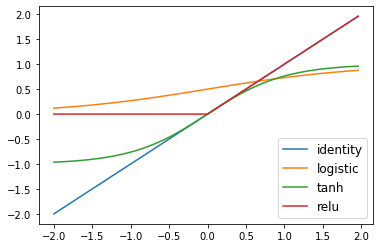

In [8]:
# jupyter lab/notebookの時のコマンド
%matplotlib inline
import matplotlib.pyplot as plt
x = 4*np.arange(100) / 100 - 2.0
plt.plot(x, x, label="identity") # identity
plt.plot(x, 1.0 / (1.0 + np.exp(-x)), label="logistic") # logistic
plt.plot(x, np.tanh(x), label="tanh") # tanh
plt.plot(x, np.maximum(x, 0), label="relu") # relu
plt.legend(fontsize=12, loc='lower right')
plt.show()

異常な結果となった`"identity"`と`"relu"`は非有界（=関数の値がどこまでも大きくなる or 小さくなる）ですが，（お世辞にも良い結果ではないですが）正常に働いた`"logistic"`と`"tanh"`は有界(前者は$(0, 1)$，後者は$(-1, 1)$)です．
そのため，以下のようなことが起こっているのではないかと考えられます：**活性化関数に通す前の中間層の値が非常に大きくなってしまっているのではないか？**

活性化関数に通す前の値は，「入力ベクトルと重み行列の積」によって計算されます．
したがって，特徴ベクトルの値が大きい場合，中間層の値が非常に大きくなってしまう可能性があります．
特徴ベクトルの値をちょっと思い出してみます．
one-hotエンコーディングによって作られた部分は0か1でした．
各サイズで売れた数を表す部分は，かなり大きな数字が入っていたような記憶があると思います．
ちょっと見てみましょう．

In [9]:
print(d_train)
print(np.max(X_train))

             Date         4046         4225       4770  Small Bags  \
0      2017-04-23      1121.34      5184.26       0.00      888.21   
1      2017-09-17   1582315.47   1095433.56   47072.46   863081.25   
2      2017-11-05       141.41       794.48       0.00     5320.50   
3      2016-01-24      5289.88       111.58       0.00     5096.27   
4      2018-01-28  14551799.50  12119884.61  575974.74  9749412.19   
...           ...          ...          ...        ...         ...   
12769  2015-07-12      1639.19        49.62       0.00     3592.55   
12770  2016-01-31      8791.51     58433.15       0.00     6581.99   
12771  2018-01-21       613.65      1852.11       0.00     4083.63   
12772  2016-07-31       553.48         5.70       0.00     4514.72   
12773  2015-03-15    156506.22    160239.43   17300.74    58756.28   

       Large Bags  XLarge Bags          type            region  
0         2717.94         0.00       organic          LasVegas  
1       591149.15      2174.9

最大で8ケタの非常に大きな値が入っており，先程述べていたことが起こっている可能性が高そうに思えてきます．
また，そもそも，特徴の値の最大値と最小値の範囲が，各特徴毎に大きく異なるというのは問題となることがあります．
線形モデルの例を考えてみます．
one-hotエンコーディングされたある特徴（たとえば，`"region_LasVegas"`）の重みを$w_j$，あるサイズとして売れた数（たとえば，`4046`）に関する重みを$w_i$とし，$w_j=w_i=0.01$であるとします．
このとき，one-hotエンコーディングされたある特徴の重み$w_j=0.01$であることに大きな問題はなさそうです：$x_j$は最大でも$1$なので，$x_j=0$の場合と比較しても予測の値が$0.01$増えるだけです．
一方で，売れた数に関する重み**$w_i=0.01$は問題が起こります**：$x_i$の値が，例えば上で出ている最大値`22743616.17`のとき，$x_i=0$の場合と比較して，**予測の値がおよそ227436も増えてしまいます**．
つまり，各特徴に対応するパラメータ（上の例では，$w_j$や$w_i$）のスケールは，その特徴のスケールに応じて適切なものになってなければなりません．

[sklearnのニューラルネットワークに関する解説](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use)を見てみましょう．
次のように書いてあります：

- "Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1. Note that you must apply the same scaling to the test set for meaningful results. You can use StandardScaler for standardization."

ようするに，**MLPは特徴のスケールに影響を受けやすいので，そこらへんはどうにかしなさい（例えば，各特徴の値が$[0, 1]$や$[-1, 1]$の範囲に入るようにであったり，平均が0で分散が1になるようにしなさい）**と言っています．
このように，学習アルゴリズムに入れる前に，特徴量に対して何らかの変換を施すことを**前処理（preprocessing）**と言います（one-hotエンコーディングも前処理の一部であると言えるでしょう）．

## `sklearn.preprocessing`：sklearnの機能を使って特徴量のスケールを揃える

さて，それでは上で言われているように，特徴ベクトルのスケールを揃えてみましょう．
今回は各特徴量を`[0, 1]`の範囲に（=最小値が0で最大値が1になるように）スケーリングします．
numpyの演算を使うことでも比較的簡単にできますが，ここではsklearnの機能を使うことにします．

sklearnには`sklearn.preprocessing`というモジュールがあり，このモジュールの中に様々な前処理のための関数・クラスが用意されています．
今回は，**最大値と最小値を揃えるスケーリング**を行いたいわけですが，これは`sklearn.preprocessing`の中の`MinMaxScaler`によって行うことができます．

そこで，今回のQuizです．

### Quiz 1
[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)を使って，各特徴の値を[0,1]の範囲にスケーリングした訓練データ`X_train_scaled`を作成し，`X_train_scaled`を用いて`MLPRegressor()`の交差検証を行してください．

In [10]:
from sklearn.preprocessing import MinMaxScaler

# 以下を埋める


X_train_scaled =  # ここを埋める

# モデルを作成し，交差検証で評価
mlp = MLPRegressor()
scores = cross_validate(mlp, X_train_scaled, y_train, cv=5, 
                        scoring="neg_mean_squared_error",
                        return_train_score=True)
print(f"交差検証の5回のスコア：{-scores['test_score']}")
print(f"交差検証の平均スコア：{-np.mean(scores['test_score'])}")

print(f"交差検証の5回の訓練スコア：{-scores['train_score']}")
print(f"交差検証の平均訓練スコア：{-np.mean(scores['train_score'])}")

交差検証の5回のスコア：[0.03407623 0.03111196 0.03084854 0.02956114 0.03339093]
交差検証の平均スコア：0.031797759577266514
交差検証の5回の訓練スコア：[0.00243832 0.00273227 0.0021143  0.00203041 0.00230025]
交差検証の平均訓練スコア：0.0023231097986461864


信じられないほど改善しました！
しかもまだ細かい交差検証はしていませんから，更に性能の向上を見込めます．

交差検証をして良いパラメータを定めてみましょう．
前回の復習も兼ねて，続けてクイズです．

### Quiz 2
`X_train_scaled`を訓練データの入力として，`MLPRegressor`のハイパーパラメータを`GridSearchCV`によってチューニングしてください．
ここで，以下の2つのパラメータを次で示す範囲でチューニングすること：
- `hidden_layer_sizes`：(1)中間層が一つでユニット数が100 (2)中間層が2つでユニット数がそれぞれ80
- `activation`：(1) "logistic" (2) "tanh" (3) "relu"

また，計算時間の削減のため反復数`max_iter`は100とし，乱数の初期SEEDを定める`random_state`は765としてください．交差検証の分割数は5，スコア関数は`"neg_mean_squared_error"`とすること．
そして最後に，最も良かったハイパーパラメータの組と，その時の交差検証のスコアを`print`してください．
その際に，交差検証のスコアは正負を反転させて平均二乗誤差にしてください．

In [11]:
mlp = # ここを埋める
params_grid = {} # ここを埋める
# 以下を埋める

/home/kyohei/.local/share/virtualenvs/pipenv3.8.1-zyzkCb9a/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kyohei/.local/share/virtualenvs/pipenv3.8.1-zyzkCb9a/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kyohei/.local/share/virtualenvs/pipenv3.8.1-zyzkCb9a/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kyohei/.local/share/virtualenvs/pipenv3.8.1-zyzkCb9a/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic 

{'activation': 'tanh', 'hidden_layer_sizes': (80, 80)}
0.024242445515821536


/home/kyohei/.local/share/virtualenvs/pipenv3.8.1-zyzkCb9a/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


最も良かったハイパーパラメータとその時のスコアについて，TFの環境では以下の結果が得られました：

`{'activation': 'tanh', 'hidden_layer_sizes': (80, 80)}`

`0.024242445515821536`

この結果で得られたベストなモデルを使って予測結果を提出すると良いかもしれません．
その際，**テストデータの変換を行うのを忘れる・変換の仕方を誤る**と，ひどいスコアとなってしまうためご注意ください．
なお，上のチューニングはかなり粗く・雑に行っているので，より丁寧に行うことでより良いスコアが出る可能性は高いです．

## まとめ
- 多層パーセプトロン（MLP)：ニューラルネットワークの一種．（非線形な活性化関数を使った場合）非線形なモデルで，特徴ベクトルのスケールに影響を強く受ける．
- 前処理のための関数やクラスは`sklearn.preprocessing`にある．最大値と最小値のスケーリングは`MinMaxScaler`で行うことができる．

今回用いた`MinMaxScaler`以外にも前処理のクラス・関数は多数あるので，それらについても調べてみる・使ってみると良いかもしれません．
また，具体的に名前を列挙することはしませんが，非線形なモデルは`MLPRegressor`以外にも多数あります．
その中には，特徴ベクトルのスケールの影響を受けにくく，使いやすいモデルもあります．
また，興味深いことに，カテゴリカル変数をそのまま扱える手法もあります（残念ながらsklearnの実装ではそうなっておらず，その手法に特化したライブラリを使う必要がありますが）．
「どのような特徴を作るか」「どのような変換を施すか」「どのようなモデルを使うか」「どのようなハイパーパラメータにするか」を考えると，できることは山ほどあるので，是非色々試してみてください．

さらに，ここ10年弱の深層学習ブームにより，ニューラルネットワークのライブラリが多数開発されています．
それらを用いることでより自由に・柔軟にニューラルネットワークを（MLPを）構築することができます．
それらについても興味があれば調べてみると良いかもしれません．

今回は，予測モデルを構築する前の処理として，スケーリングを取り上げました．
それ以外にも，例えば
- 特徴選択（feature selection）：元の特徴量からいくつかの特徴量を選ぶ (特徴選択で作られた低次元ベクトルは，元の特徴ベクトルの部分ベクトル)
- 特徴抽出（feature extraction)：元の特徴量を用いて新しく（低次元の）特徴量を作り出す(元の特徴ベクトルの部分ベクトルとは限らない）

等の処理を行うと，性能が向上することもあります．
これらはsklearnでは[sklearn.feature_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)や[sklearn.decomposition](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition)に実装されています．
余裕がある方は試してみると良いかもしれません．

### Quiz 1

`from sklearn.preprocessing import MinMaxScaler`で使えるようになります．
`MinMaxScaler`は，標準では[0,1]にスケーリングするため，特に引数の設定をすることなくインスタンスを作成します．
ドキュメントを読んでみると分かりますが，`fit`メソッドで各特徴量の最大値と最小値を計算し，`transform`メソッドで変換を施した行列を返します．
そのため，以下のようになります．

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 以下を埋める
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train) # ここを埋める

# モデルを作成し，交差検証で評価
mlp = MLPRegressor()
scores = cross_validate(mlp, X_train_scaled, y_train, cv=5, 
                        scoring="neg_mean_squared_error",
                        return_train_score=True)
print(f"交差検証の5回のスコア：{-scores['test_score']}")
print(f"交差検証の平均スコア：{-np.mean(scores['test_score'])}")

print(f"交差検証の5回の訓練スコア：{-scores['train_score']}")
print(f"交差検証の平均訓練スコア：{-np.mean(scores['train_score'])}")

### Quiz 2

In [14]:
mlp = MLPRegressor(max_iter=100, random_state=765) # ここを埋める
params_grid = {
    "hidden_layer_sizes": [(100, ), (80, 80)],
    "activation": ["logistic", "tanh", "relu"],} # ここを埋める
# 以下を埋める
cv = GridSearchCV(mlp, param_grid=params_grid, cv=5, scoring="neg_mean_squared_error") # 
cv.fit(X_train_scaled, y_train)
print(cv.best_params_) # 最も良かったハイパーパラメータを見てみる
print(-cv.best_score_) # 最も良かったハイパーパラメータの時のスコアを見てみる．わかりやすさのため符号は反転する．

/home/kyohei/.local/share/virtualenvs/pipenv3.8.1-zyzkCb9a/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kyohei/.local/share/virtualenvs/pipenv3.8.1-zyzkCb9a/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kyohei/.local/share/virtualenvs/pipenv3.8.1-zyzkCb9a/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kyohei/.local/share/virtualenvs/pipenv3.8.1-zyzkCb9a/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic 

{'activation': 'tanh', 'hidden_layer_sizes': (80, 80)}
0.024242445515821536


/home/kyohei/.local/share/virtualenvs/pipenv3.8.1-zyzkCb9a/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
